In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt


In [3]:
# Load dataset created in Notebook 3
df = pd.read_csv('../data/cleaned/time_aware_churn_dataset.csv')

df.head()


,Customer ID,Recency,Tenure,Frequency,Monetary,AvgOrderValue,PurchaseVelocity,Churn
0,12346,162,562,12,77556.46,2281.072353,0.021352,1
1,12347,20,241,5,3529.27,20.400405,0.020747,0
2,12348,85,275,4,1709.40,35.612500,0.014545,0
3,12349,244,426,3,2671.14,26.187647,0.007042,1
4,12350,147,147,1,334.40,19.670588,0.006803,1


In [4]:
# Separate features and target
X = df.drop(columns=['Customer ID', 'Churn'])
y = df['Churn']

X.head()


,Recency,Tenure,Frequency,Monetary,AvgOrderValue,PurchaseVelocity
0,162,562,12,77556.46,2281.072353,0.021352
1,20,241,5,3529.27,20.400405,0.020747
2,85,275,4,1709.40,35.612500,0.014545
3,244,426,3,2671.14,26.187647,0.007042
4,147,147,1,334.40,19.670588,0.006803


In [5]:
# Stratified split to preserve churn distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((4030, 6), (1008, 6))

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Linear interpretable model
log_model = LogisticRegression(
    class_weight='balanced',  # handle class imbalance
    max_iter=1000
)

log_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_model.predict(X_test_scaled)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Results")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_log))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       341
           1       0.84      0.72      0.77       667

    accuracy                           0.72      1008
   macro avg       0.70      0.72      0.71      1008
weighted avg       0.75      0.72      0.73      1008

ROC-AUC: 0.7964492826900332


In [8]:
# Non-linear ensemble model
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest Results
              precision    recall  f1-score   support

           0       0.67      0.54      0.60       341
           1       0.79      0.87      0.82       667

    accuracy                           0.76      1008
   macro avg       0.73      0.70      0.71      1008
weighted avg       0.75      0.76      0.75      1008

ROC-AUC: 0.7911821215491961


In [9]:
cm = confusion_matrix(y_test, y_pred_rf)

print("Confusion Matrix (Random Forest)")
print(cm)


Confusion Matrix (Random Forest)
[[185 156]
 [ 90 577]]


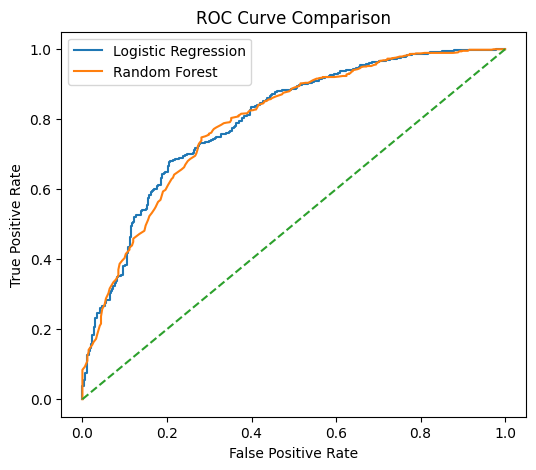

In [10]:
# Compare model performance visually
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,5))

plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.show()


In [12]:
# Create final predictions dataframe (using Random Forest)

final_predictions = X_test.copy()

final_predictions['Customer ID'] = df.loc[X_test.index, 'Customer ID'].values
final_predictions['Churn_Probability'] = y_proba_rf
final_predictions['Predicted_Churn'] = y_pred_rf
final_predictions['Actual_Churn'] = y_test.values

final_predictions.head()


,Recency,Tenure,Frequency,Monetary,AvgOrderValue,PurchaseVelocity,Customer ID,Churn_Probability,Predicted_Churn,Actual_Churn
2424,62,571,5,1417.95,41.704412,0.008757,15223,0.715,1,1
1655,47,309,3,559.48,29.446316,0.009709,14342,0.545,1,0
3351,251,479,2,460.08,16.431429,0.004175,16310,0.930,1,1
2765,479,479,1,596.67,15.299231,0.002088,15631,0.900,1,1
2028,5,388,9,5614.08,18.839195,0.023196,14766,0.220,0,0


In [16]:
final_predictions.to_csv("../data/cleaned/model_predictions.csv", index=False)


In [15]:
y_pred_rf
y_proba_rf


array([0.715, 0.545, 0.93 , ..., 0.135, 0.995, 0.405], shape=(1008,))